# A Bayesian Network to Model the Effects of an Epidemic on a Nation
### Student: Andrea Rossolini 954735
In the following notebook, I developed a highly simplified Bayesian network to model the main consequence of an epidemic breakout in a nation, based on its population, density, GDP, health care quality and restriction policies taken into account by that specific country.

The network is based on the famous SIR model. These variables (S, I, and R) represent the number of people in each compartment at a particular time:
<ul>
    <li>S: percentage of susceptible individuals within the population</li>
    <li>I: percentage of infected individuals within the susceptibles</li>
    <li>R: percentage of removed individuals within the infected </li>
</ul>

The last state of this model can be divided in two different states: <i>recovered</i> and <i>deceased</i>. With this extension, the network can be more complex and interesting to analyze.

Such a model should be represented as a probabilistic reasoning model over time, to simplify this process I decided to model the consequence of a pandemic after a defined time. Thus, the following network represents a static model.

<b>Note</b><br>
The model takes as an example of the epidemic of COVID-19 and its effects on a nation in a time frame of two months [8].
The model, as said before, is oversimplified. It does not take into account the economic damages that an epidemy can bring to a country (and affect the GDP), social behaviour during the pandemic, the observance of the rules (social distances, wearing masks, compliance with a possible lockdown), level of domestic and international tourism, country costumes and so forth.

This project uses the library <b>pgmpy</b> to build the network and compute the operations on it.
By the fact there not exists complete data from which pgmpy can learn to build the network; I created some artificial values, while others are taken from different sources (see at the bottom). All the data are taken into account date back to August 2020.
To simplify this work continuous variables had been divided into groups.

In [1]:
import numpy as np
from scipy.stats import beta
from scipy.integrate import simps
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

from IPython.display import Image
# To build the node "Infected"
from matplotlib import pyplot as plt 
from scipy.stats import beta

# Used in section 3
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import State
from pgmpy.sampling import BayesianModelSampling, GibbsSampling

Starting from the SIRD model explained above, we can describe all the features of the network. The following bullet list defines all the nodes of the network and their possible states. Moreover, it gives some examples of some countries which are then used for tests in section 3. The network has been inspired by the studies carried out by the Bayesianlab [6] - [7].

<br>
<ul>
    <li><b>Dens</b> = Density (pop./km^2):</li>
        <ul>
            <li>Very_low (< 30 e.g. Canada) 48/195</li>
            <li>Low ([30,100] e.g. Brazil or USA)  64/195</li>
            <li>Medium ([100,300] e.g. Italy) 55/195</li>
            <li>High ([300,600] e.g. Netherlands) 18/195</li>
            <li>Very_high (> 600 e.g. Bangladesh) 10/195</li>
        </ul>
    <li><b>Pop</b> = Population
        <ul>
            <li>Very_low (< 1,000,000 e.g. Luxemburg) 39/195</li>
            <li>Low ([1, 10] million e.g. Austria) 66/195</li>
            <li>Medium ([10, 100] million e.g. Italy) 76/195</li>
            <li>High ([100m, 1b]  e.g. Brazil) 12/195</li>
            <li>Very_high ([> 1b] e.g. India) 2/195</li>
        </ul>
    </li>
    <li><b>RP</b>  = Restriction Policies: rules and laws used to contain the spreading
        <ul>
            <li>None   (e.g. herd immunity)</li>
            <li>Light  (e.g. mask mandatory in public spaces, ban on gathering)</li>
            <li>Medium (e.g. Lockdown with exceptions for workers, travel restrictions)</li>
            <li>Severe (e.g. Lockdown including productive activities, country isolation)</li>
            <li>Extreme (e.g. Martial law)</li>
        </ul>
    </li>
    <li><b>GDP</b> = Gross Domesti Product</li>
    <ul>
        <li>Low  (< 100b e.g. Luxemburg) 131/165</li>
        <li>Medium ([100b, 1t] e.g. Netherlands) 48/195</li>
        <li>High (> 1t e.g. Italy) 16/195</li>
    </ul>
    <li><b>S</b>  = Susceptible: percentage of susceptible individuals within the population (people cannot be susceptible for different reasons as immunity, life style, age ...)</li>
    <ul>
        <li>Medium (at least 75% of population)</li>
        <li>High (at least 90% " ")</li>
    </ul>
    <li><b>Age</b> = Average Age</li>
    <ul>
        <li>Young  (< 20) 40/230 </li>
        <li>Avg    ([20, 40]) 140/230</li>
        <li>Old    (> 40) 50/230</li>
    </ul>
    <li><b>I</b> = Infected: percentage of infected individuals within the susceptibles/li>
    <ul>
        <li> Low (< 0.3% e.g. Mongolia) </li>
        <li> Medium ([0.3,0.8%] e.g. Italy)</li>
        <li> High (>0.8% e.g. USA)</li>
    </ul>
    <li><b>HC</b> = Health Care system overall performances (based on WHO health systems ranking [5]) </li>
    <ul>
        <li>Weak</li>
        <li>Strong</li>
    </ul>
    <li><b>De</b> = Deceased: percentage of deceased individuals within the infected </li>
    <ul>
        <li>Low  (< 4% of infected died)</li> 
        <li>High (> 4% of infected died)</li>
    </ul>
    <li><b>Re</b> = Recovered: percentage of recovered individuals within the infected  </li>
    <ul>
        <li>Low  (< 50% of infected recovered)</li>
        <li>High (> 50% of infected recovered)</li>
    </ul>
</ul>

# 1. Model definition


According to the features defined above, the representation of the netwrok follows.

Using pgmpy we can simply write:

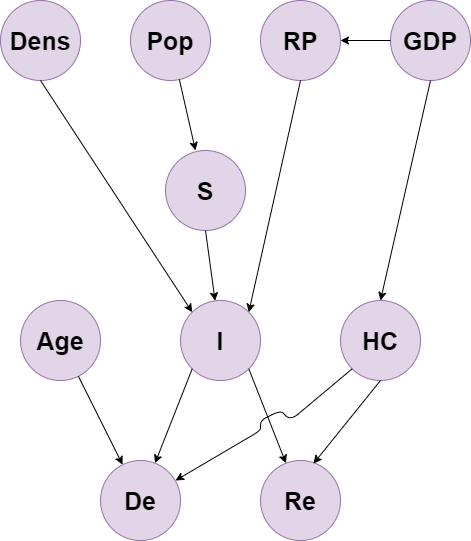

In [2]:
model = BayesianModel([('Dens', 'I'), ('Pop', 'S'), ('GDP', 'RP'), ('GDP', 'HC'),
                       ('RP', 'I'), ('S', 'I'), ('Age', 'De'), ('I', 'De'),
                       ('I', 'Re'), ('HC', 'De'), ('HC', 'Re')])

Image(filename="../res/chart.png") # Hand-made network

Now we must define the values for the conditional probability tables. <b> The numbers we use are rather arbitrary guesses and we do not pretend them to be anyhow realistic.</b>
<br>For the node without parents (density, population, GDP, the average age of each country) it is simple: I used the data from  [1], [2], [3], [4].

In [3]:
# Defining CPD of nodes without parents (leaves)
den_cpd = TabularCPD(variable='Dens',variable_card=5, 
                    values=[[0.24615384615384617], [0.3282051282051282], [0.28205128205128205],
                    [0.09230769230769231], [0.05128205128205128]],
                    state_names={'Dens': ['Very_low', 'Low', 'Medium', 'High', 'Very_high']})
pop_cpd = TabularCPD(variable='Pop',variable_card=5, 
                    values=[[0.2], [0.3384615384615385], [0.38974358974358975],
                    [0.06153846153846154], [0.010256410256410256]],
                    state_names={'Pop': ['Very_low', 'Low', 'Medium', 'High', 'Very_high']})
gdp_cpd = TabularCPD(variable='GDP',variable_card=3, 
                    values=[[0.6717948717948717], [0.24615384615384617], [0.08205128205128205]],
                    state_names={'GDP': ['Low', 'Medium', 'High']})
age_cpd = TabularCPD(variable='Age',variable_card=3, 
                    values=[[0.17391304347826086], [0.6086956521739131], [0.21739130434782608]],
                    state_names={'Age': ['Young', 'Avg', 'Old']})

model.add_cpds(den_cpd, pop_cpd, gdp_cpd, age_cpd)

The following cell defines <i>Susceptibles</i>, <i>Health Care system</i>, and <i>Restriction Policies</i> probabilities.

Following the SIRD model, the Susceptibles node is influenced by the population only. This influence is given because, the more people a country has the more is the probability that some characteristic (such as an immune system or abide or a specific gene) developed inside a country, and allow a restricted number of individuals to be immune to the disease. While Restriction Policies and Health Care system are both influenced by the GDP. Indeed, strong economies (e.g. France) usually have a well-developed health care system, but it is not always true (e.g. India). Moreover, a greater GDP means that, during a pandemic, the country can invest more in medical tools such as masks, artificial lungs, painkillers, and so on. Besides, the restriction policies are usually harder when a country can afford it (e.g. Italy), but sometimes some rich countries take the risks of the pandemic without efforts (e.g. UK in summer 2020).


In [4]:
# Defining CPD of nodes with one parent
sus_cpd = TabularCPD(variable='S',variable_card=2, 
                     values=[[0.3, 0.35, 0.4, 0.45, 0.50], [0.7, 0.65, 0.6, 0.55, 0.5]],
                     evidence=['Pop'],
                     evidence_card=[5],
                     state_names={'S': ['Medium', 'High'],
                                 'Pop': ['Very_low', 'Low', 'Medium', 'High', 'Very_high']})
HC_cpd = TabularCPD(variable='HC',variable_card=2, 
                     values=[[0.83, 0.42, 0.05], [0.17, 0.58, 0.95]],
                     evidence=['GDP'],
                     evidence_card=[3],
                     state_names={'HC': ['Weak', 'Strong'],
                                 'GDP': ['Low', 'Medium', 'High']})
RP_cpd = TabularCPD(variable='RP',variable_card=5,
                     values=[[0.29, 0.21, 0.12], 
                             [0.32, 0.37, 0.28], 
                             [0.19, 0.26, 0.39], 
                             [0.11, 0.13, 0.205], 
                             [0.09, 0.03, 0.005]],
                     evidence=['GDP'],
                     evidence_card=[3],
                     state_names={'RP': ['None', 'Light', 'Normal', 'Severe', 'Extreme'],
                                 'GDP': ['Low', 'Medium', 'High']})

model.add_cpds(sus_cpd, HC_cpd, RP_cpd)

The node "Infected" is influenced by the density of the country. Indeed, in a very dense country (e.g. Bangladesh), people enter in contact with each other more frequently. Besides, the restriction policies limit the contact and the spreading of a virus.

Considering that there is no enough data online to generate (or let the network learn somehow) the whole 150 probabilities for the infection table, I used <i>Beta distributions</i> to create a reasonable and coherent data.

The goal is to produce data in a way that a highly susceptible population would increase the dimension of the number of infectious. Same with density: in a country with a high population density, people tend to get in touch with infectious more frequently. On the other hand, the restriction policies influence the infectiousness oppositely, so hard restriction policies mean less infects.

Firstly, I studied limits within a Beta distribution could be able to represent what I was searching for. Secondly, for each combination of values (e.g. S=medium, Dens=High, RP=Extreme and so on) I generated a reasonable distribution. So if we have, for example, a high susceptibility, a very high density of population, and no restriction policies, the curve would have it's maximum closer to the right limit.

For each distribution, I extracted three values by dividing the distribution into three parts, and integrate the three parts following the <i>Simpson's rule</i>. In this way, the algorithm generates the three values for the three variables (Low, Medium, High) for each combination of parameters.

In this way, I can obtain $5\times5\times2\times3=150$ values

The results follow:

Example of a Beta distribution:


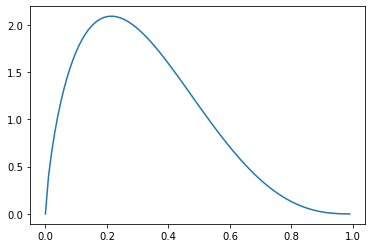

In [5]:
b = 3.75
a = 1.75

x = np.arange(0.0, 1, 0.01)
y = beta.pdf(x,a,b)
plt.plot(x,y)
print("Example of a Beta distribution:")
plt.show()

In [6]:
S = [0.5, 0.75]
Dens = [1.5, 2, 3, 4, 4.5]
RP = [1, 0.5, 0, -0.5, -1]
min_ = 1.5
max_ = 6

res = []
for es in S :
    for d in Dens:
        for rp in RP:
            tmp = es+d+rp
            if tmp < min_ :
                tmp=min_
            if tmp > max_ :
                tmp=max_
            res.append(tmp)

low, med, hig = [], [], []
x = np.arange(0.01, 1, 0.01)
b = 3.5
for a in res :
    y = beta.pdf(x,a,b)
    # Simpson's rule
    low.append(round(simps(y[:34])/100, 3))  
    med.append(round(simps(y[33:67])/100, 3))
    hig.append(round(simps(y[66:])/100, 3))

In [7]:
# We use the lists found above to generate a reasonable Infected's CPD
I_cpd = TabularCPD(variable='I',variable_card=3, 
                     values=[low, med, hig],
                     evidence=['Dens', 'RP', 'S'],
                     evidence_card=[5,5,2],
                     state_names={'I':['Low','Medium', 'High'],
                                  'Dens': ['Very_low', 'Low', 'Medium', 'High', 'Very_high'],
                                  'RP': ['None', 'Light', 'Normal', 'Severe', 'Extreme'],
                                  'S': ['Medium', 'High']})
model.add_cpds(I_cpd)

Now we can simply build the two remaining tables:
The number of recovered is influenced by the number of infected and the quality of the health care system. An efficient HC system can handle and cure a huge number of infected. While, a country that has a bad HC system, and where the population is old and fragile, it will record more losses.

In [8]:
Re_cpd = TabularCPD(variable='Re',variable_card=2, 
                     values=[[0.4,0.2,0.5,0.3,0.6,0.4], [0.6,0.8,0.5,0.7,0.4,0.6]],
                     evidence=['I', 'HC'],
                     evidence_card=[3,2],
                     state_names={'Re': ['Low', 'High'],
                                  'I': ['Low', 'Medium', 'High'],
                                  'HC': ['Weak', 'Strong']})

De_cpd = TabularCPD(variable='De', variable_card=2,
                   values=[[0.40,0.85,0.50,0.80,0.60,0.75,
                            0.50,0.80,0.40,0.75,0.30,0.70,
                            0.40,0.75,0.30,0.70,0.20,0.65],
                           [0.60,0.15,0.50,0.20,0.40,0.25,
                            0.50,0.20,0.60,0.25,0.70,0.30,
                            0.60,0.25,0.70,0.30,0.80,0.35]],
                   evidence=['Age','I','HC'],
                   evidence_card=[3,3,2],
                   state_names={'De': ['Low','High'],
                                'Age': ['Young', 'Avg', 'Old'],
                                'I': ['Low', 'Medium', 'High'],
                                'HC': ['Weak', 'Strong']})

model.add_cpds(De_cpd, Re_cpd)

All tables are summarised below.

In [9]:
print('Check model: {0}\n'.format(model.check_model()))
for cpd in model.get_cpds():
    print('CPT -- {0}:'.format(cpd.variable))
    print(cpd, '\n')

Check model: True

CPT -- Dens:
+-----------------+-----------+
| Dens(Very_low)  | 0.246154  |
+-----------------+-----------+
| Dens(Low)       | 0.328205  |
+-----------------+-----------+
| Dens(Medium)    | 0.282051  |
+-----------------+-----------+
| Dens(High)      | 0.0923077 |
+-----------------+-----------+
| Dens(Very_high) | 0.0512821 |
+-----------------+-----------+ 

CPT -- Pop:
+----------------+-----------+
| Pop(Very_low)  | 0.2       |
+----------------+-----------+
| Pop(Low)       | 0.338462  |
+----------------+-----------+
| Pop(Medium)    | 0.389744  |
+----------------+-----------+
| Pop(High)      | 0.0615385 |
+----------------+-----------+
| Pop(Very_high) | 0.0102564 |
+----------------+-----------+ 

CPT -- GDP:
+-------------+-----------+
| GDP(Low)    | 0.671795  |
+-------------+-----------+
| GDP(Medium) | 0.246154  |
+-------------+-----------+
| GDP(High)   | 0.0820513 |
+-------------+-----------+ 

CPT -- Age:
+------------+----------+
| Age(Young

# 2. Network Analysis
<i>Pgmpy</i> allows to easily investigate the properties of the network, indeed it is possible to individuate flows of probabilistic influence, active trials, check the conditionals independence relations between features of the Bayesian network and moreover. In the following cells it is possible to notice these characteristics:

* The leaves (terminal nodes, thus without children) and root nodes (nodes without parents)
* <b>d-separation principle</b>: principle that determines whether a set <i>X</i> of variables is independent from another set <i>Y</i>, given a third set <i>Z</i>. 
* <b>Active trial</b>: If influence can flow from X to Y via Z the trial X⇌Z⇌Y is active. So, if there's no <i>active trial</i> between two variables $X\ \&\ Y$ they are d-separated.
* <b>Markov Blanket</b>: The set of <i>parents, children, and children's parents</i> of a node $\rightarrow$ the Markov Blanket is the minimal set of nodes which <i>d-separates</i> a particular node from all the others

The investigation can be performed on <b>single nodes</b>, for example:

In [10]:
#Checking Cardinality of a Node (Population)
card_pop = model.get_cardinality('Pop')

#Getting Children of a Node (Infection)
child_Inf = model.get_children('I')

#Getting predecessors of a node (Infection)
pred_Inf = list(model.predecessors("I"))

#Getting successors of a node
succ_HC =list(model.successors("HC"))

#Getting Markov Blanket of a node
mb_Inf = model.get_markov_blanket('I')

# Getting the local independencies of one or more nodes.
model.local_independencies('De')
local_inds = model.local_independencies(['I','De'])

#Individuate active trials
act_trials_inf = model.active_trail_nodes('I', observed='GDP')

print(f'The cardinality of the node \'population\' is\n{card_pop}\n')
print(f'The children of the node \'Infected\' are \n{child_Inf}\n')
print(f'The predecessors of the node \'Infected\' are \n{pred_Inf}\n')
print(f'The successors of the node \'Health Care\' are \n{succ_HC}\n')
print(f'The Markov Blanket of the node \'Infected\' is \n{mb_Inf}\n')
print(f'The local independencies of the nodes \'Infected\' and \'Deaths\' are\n{local_inds}\n')
print(f'The active trials of the node \'Infected\', considering \'GDP\'\n{act_trials_inf}\n')

The cardinality of the node 'population' is
5

The children of the node 'Infected' are 
['De', 'Re']

The predecessors of the node 'Infected' are 
['Dens', 'RP', 'S']

The successors of the node 'Health Care' are 
['De', 'Re']

The Markov Blanket of the node 'Infected' is 
['De', 'S', 'Dens', 'Re', 'RP', 'Age', 'HC']

The local independencies of the nodes 'Infected' and 'Deaths' are
(I _|_ HC, Pop, Age, GDP | RP, S, Dens)
(De _|_ Re, S, Dens, Pop, GDP, RP | Age, I, HC)

The active trials of the node 'Infected', considering 'GDP'
{'I': {'De', 'S', 'Re', 'Dens', 'RP', 'Pop', 'I'}}



The investigation can be performed <b>globally</b> on the whole network:

In [11]:
# Getting the list of leaves of the network
leaves = list(model.get_leaves())

# Getting the list of roots of the network
roots = model.get_roots()

# Getting the nodes of the network
nodes = list(model.nodes())


# Getting the Markov blanket of all non-leaves nodes
markov_blankets = {}
for node in list(set(nodes) - set(leaves)) :
    markov_blankets[node] = model.get_markov_blanket(node)


print("="*100)
print(f'the number of nodes of the network is {len(nodes)}')
print(f'the leaves of the network are {leaves}')
print(f'the roots of the network are {roots}')
print("="*100)
[print(f'The Markot Blanket of the node {k} is {v}') for k,v in markov_blankets.items()]
print("="*100)

def there_s_an_active_trial(nodes):
    print(f"Is there an active trial between {nodes}?")
    if model.is_active_trail(*nodes):
        print(f"Yes, there is")
    else:
        print("No, there isn't")
        inter = list(model.active_trail_nodes(nodes[0]).get(nodes[0]))
        for node in nodes[1:]:
            list_2 = list(model.active_trail_nodes(node).get(node))
            inter = list(filter(lambda x : x in inter, list_2))
        print(f"Try to consider one of these nodes {inter}")
        
        
        

there_s_an_active_trial(['Dens','Pop']) # V-structure
print()
there_s_an_active_trial(['Dens', 'Pop', 'I'])
print()
there_s_an_active_trial(['Age', 'GDP'])
print()
there_s_an_active_trial(['Age', 'GDP','De'])

the number of nodes of the network is 10
the leaves of the network are ['De', 'Re']
the roots of the network are ['Dens', 'Pop', 'GDP', 'Age']
The Markot Blanket of the node S is ['Dens', 'RP', 'Pop', 'I']
The Markot Blanket of the node Dens is ['RP', 'S', 'I']
The Markot Blanket of the node RP is ['S', 'Dens', 'I', 'GDP']
The Markot Blanket of the node HC is ['De', 'Re', 'Age', 'I', 'GDP']
The Markot Blanket of the node Age is ['De', 'I', 'HC']
The Markot Blanket of the node Pop is ['S']
The Markot Blanket of the node I is ['De', 'S', 'Dens', 'Re', 'RP', 'Age', 'HC']
The Markot Blanket of the node GDP is ['RP', 'HC']
Is there an active trial between ['Dens', 'Pop']?
No, there isn't
Try to consider one of these nodes ['Re', 'De', 'I']

Is there an active trial between ['Dens', 'Pop', 'I']?
Yes, there is

Is there an active trial between ['Age', 'GDP']?
No, there isn't
Try to consider one of these nodes ['De']

Is there an active trial between ['Age', 'GDP', 'De']?
Yes, there is


In [12]:
#get all independencies of the network

print(f'There can be made {len(model.get_independencies().get_assertions())}',
      'valid independence assertions, with respect to the all possible given evidences.\n\n',
      'For the definition of local semantics, any node in the network is independent of its non-descendents given its parents:\n',
      f'\n{model.local_independencies(nodes)}\n')

There can be made 3549 valid independence assertions, with respect to the all possible given evidences.

 For the definition of local semantics, any node in the network is independent of its non-descendents given its parents:
 
(Dens _|_ Pop, S, Age, GDP, RP, HC)
(I _|_ HC, Pop, Age, GDP | RP, S, Dens)
(Pop _|_ Dens, Age, GDP, RP, HC)
(S _|_ Dens, Age, GDP, RP, HC | Pop)
(GDP _|_ Age, S, Dens, Pop)
(RP _|_ Pop, S, Dens, HC, Age | GDP)
(HC _|_ Pop, S, Dens, I, RP, Age | GDP)
(Age _|_ Re, S, Dens, HC, RP, Pop, I, GDP)
(De _|_ Re, S, Dens, Pop, GDP, RP | Age, I, HC)
(Re _|_ De, S, Dens, RP, Pop, GDP, Age | HC, I)



In [13]:
"""
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
The functions in this cell were not made by me.

They can be found in the official repository on github:
pgmpy/pgmpy_notebook/notebooks/A Bayesian Network to model the influence of energy consumption on greenhouse gases in Italy.ipynb
"""

def independent_assertions_score_function(node):
    return len([a for a in model.get_independencies().get_assertions() if node in a.event1])

def evidence_assertions_score_function(node):
    return len([a for a in model.get_independencies().get_assertions() if node in a.event3])

def update(assertion_dict, node, score_function):
    tmp_score = score_function(node)
    if tmp_score == assertion_dict["max"]["score"]:
        assertion_dict["max"]["nodes"].append(node)
    elif tmp_score > assertion_dict["max"]["score"]:
        assertion_dict["max"]["nodes"] = [node]
        assertion_dict["max"]["score"] = tmp_score
    if tmp_score == assertion_dict["min"]["score"]:
        assertion_dict["min"]["nodes"].append(node)
    elif tmp_score < assertion_dict["min"]["score"]:
        assertion_dict["min"]["nodes"] = [node]
        assertion_dict["min"]["score"] = tmp_score  


independent_init = independent_assertions_score_function(nodes[0])
independent_dict = {"max": {"nodes": [nodes[0]], "score": independent_init}, 
                    "min": {"nodes": [nodes[0]], "score": independent_init}}
evidence_init = evidence_assertions_score_function(nodes[0]) 
evidence_dict = {"max": {"nodes": [nodes[0]], "score": evidence_init}, 
                "min": {"nodes": [nodes[0]], "score": evidence_init}} 
for node in nodes[1:]:
    update(independent_dict, node, independent_assertions_score_function)
    update(evidence_dict, node, evidence_assertions_score_function)

print(f'Nodes which appear most ({independent_dict["max"]["score"]} times) in independence assertions',
      f'as independent variable are:\n{set(independent_dict["max"]["nodes"])}')
print(f'Nodes which appear least ({independent_dict["min"]["score"]} times) in independence assertions',
      f'as independent variable are:\n{set(independent_dict["min"]["nodes"])}')
print(f'Nodes which appear most ({evidence_dict["max"]["score"]} times) in independence assertions',
      f'as evidence are:\n{set(evidence_dict["max"]["nodes"])}')
print(f'Nodes which appear least ({evidence_dict["min"]["score"]} times) in independence assertions',
      f'as evidence are:\n{set(evidence_dict["min"]["nodes"])}')

Nodes which appear most (422 times) in independence assertions as independent variable are:
{'Pop'}
Nodes which appear least (278 times) in independence assertions as independent variable are:
{'I'}
Nodes which appear most (2000 times) in independence assertions as evidence are:
{'I'}
Nodes which appear least (1251 times) in independence assertions as evidence are:
{'De'}


# 3. Inference
There are two classes of inference methods:
* <b>Exact Inference</b>: Analytical computes the conditional probability distribution over the interesting variables using posterior probability distributions
    * By Enumeration (<i>not implemented</i>)
    * Variable Eleimination
* <b>Approximate Inference</b>: Approximates the required posterior pobability distribution using sampling and/or optimization techinques
    *  Rejection Sampling 
    *  Likelihood Weighting
    *  Markov Chain Monte Carlo - MCMC

## 3.1. Exact Inference
The simplest method for Inference in Bayesian networks is through <b>Variable Elimination</b>.
The algorithm works by implicitly constructing the joint probability distribution induced by the Bayesian network. Therefore, it builds a marginal distribution over the variables of interest.

In [14]:
infer = VariableElimination(model)

evidences = {
    "Italy" :    {'Dens':'Medium',   'Pop':'Medium',   'S':'High',  'RP':'Severe','GDP':'High',  'HC':'Strong','Age':'Old'},
    "France" :   {'Dens':'Medium',   'Pop':'Medium',   'S':'High',  'RP':'Normal','GDP':'High',  'HC':'Strong','Age':'Old'},
    "Brazil" :   {'Dens':'Low',      'Pop':'High',     'S':'High',  'RP':'Light', 'GDP':'High',  'HC':'Weak',  'Age':'Avg'},
    "India" :    {'Dens':'High',     'Pop':'Very_high','S':'High',  'RP':'Light', 'GDP':'High',  'HC':'Weak',  'Age':'Avg'},
    "Belgium" :  {'Dens':'High',     'Pop':'Medium',   'S':'High',  'RP':'Light', 'GDP':'Medium','HC':'Strong','Age':'Old'},
    "Bangladesh":{'Dens':'Very_high','Pop':'Very_high','S':'Medium','RP':'Light', 'GDP':'Medium','HC':'Weak',  'Age':'Avg'},
    "Luxemburg" :{'Dens':'Medium',   'Pop':'Very_low', 'S':'High',  'RP':'None',  'GDP':'Low',   'HC':'Strong','Age':'Avg'},
    "Qatar" :    {'Dens':'Medium',   'Pop':'Low',      'S':'High',  'RP':'None',  'GDP':'Medium','HC':'Weak',  'Age':'Avg'},
    "Armenia" :  {'Dens':'Medium',   'Pop':'Very_low', 'S':'High',  'RP':'None',  'GDP':'Low',   'HC':'Weak',  'Age':'Avg'},
    "Nigeria" :  {'Dens':'Medium',   'Pop':'High',     'S':'High',  'RP':'None',  'GDP':'Medium','HC':'Weak',  'Age':'Young'},
    "Mongolia":  {'Dens':'Low',      'Pop':'Medium',                'RP':'Light', 'GDP':'Low',   'HC': 'Weak', 'Age': 'Avg'}
}


def infection_inference(country : str) :
    """
    Returns the table of infection levels of the specific country
    """
    if country in evidences :
        res = infer.query(['I'],evidence=evidences[country])
        print(f"The percentage of infect in {country} is:\n{res}")
    else :
        print("The country is not present!")
        
def death_inference(country : str) :
    """
    Returns the table of deceased levels of the specific country
    """
    if country in evidences :
        res = infer.query(['De'],evidence=evidences[country])
        print(f"The percentage of death w.r.t. infected in {country} is:\n{res}")
    else :
        print("The country is not present!")

def recovered_inference(country : str) :
    """
    Returns the table of recovered levels of the specific country
    """
    if country in evidences :
        res = infer.query(['I'],evidence=evidences[country])
        print(f"The percentage of recovered w.r.t. infected in {country} is:\n{res}")
    else :
        print("The country is not present!")

def contries_likely_to_have(characts : dict):
    """
    Take a dictionary of parameters not present in the evidences

    Returns the countries that have the most likely characteristics given the evidences
    """
    searched = set([e for e in characts.keys()])
    set_nodes = set(nodes)
    vars_ = ["Pop", "GDP", "Dens", "RP", "HC", "Age"]
    if not searched <= set(vars_):
        res = []
        max_evidences = infer.map_query(vars_, characts)
        print()
        print(f"Considering {characts}")
        print(f"Finding all the countries having {max_evidences} ...")
        for country, val in evidences.items() :
            val_filter = {k:v for k,v in val.items() if k in vars_}
            if val_filter == max_evidences:
                res.append(country)
        if len(res)==0:
            print("No country satisfies the characteristics")
        else :
            return res  
    else :
        print(f"{searched - set_nodes}: invalid characteristic(s)")

In [15]:
infection_inference("Nigeria")
death_inference("Italy")
recovered_inference("France")

Eliminating: Re: 100%|██████████| 2/2 [00:00<00:00, 333.03it/s]
The percentage of infect in Nigeria is:
+-----------+----------+
| I         |   phi(I) |
+===========+==========+
| I(Low)    |   0.0480 |
+-----------+----------+
| I(Medium) |   0.5730 |
+-----------+----------+
| I(High)   |   0.3790 |
+-----------+----------+
The percentage of death w.r.t. infected in Italy is:
+----------+-----------+
| De       |   phi(De) |
+==========+===========+
| De(Low)  |    0.7171 |
+----------+-----------+
| De(High) |    0.2829 |
+----------+-----------+
The percentage of recovered w.r.t. infected in France is:
+-----------+----------+
| I         |   phi(I) |
+===========+==========+
| I(Low)    |   0.2360 |
+-----------+----------+
| I(Medium) |   0.6010 |
+-----------+----------+
| I(High)   |   0.1630 |
+-----------+----------+


In [16]:
contries_likely_to_have({"I":"High", "Re":"High", "De":"Low"})
print()
contries_likely_to_have({"Re":"Low"})

Eliminating: I: 100%|██████████| 3/3 [00:00<00:00, 26.55it/s]

Considering {'I': 'High', 'Re': 'High', 'De': 'Low'}
Finding all the countries having {'Pop': 'Medium', 'GDP': 'Low', 'Dens': 'Medium', 'RP': 'None', 'HC': 'Weak', 'Age': 'Avg'} ...
No country satisfies the characteristics


Considering {'Re': 'Low'}
Finding all the countries having {'Pop': 'Medium', 'GDP': 'Low', 'Dens': 'Low', 'RP': 'Light', 'HC': 'Weak', 'Age': 'Avg'} ...


['Mongolia']

### 3.2. Approximate Inference
The <i> Exact inferece</i> works with the prior distribution. Unluckily, for most cases, the posterior is not available. The notion of approximate inference addresses this issue exactly. Indeed, to solve the lack of posterior distribution we can turn the inference problem into a sampling one. In this way, we have an approximate posterior distribution.

#### 3.2.1 Rejection sampling
This algorithm simulates basic real-world empirical sampling. Firstly, it generates samples from the prior distribution specified by the network. Secondly, it <i>rejects</i> all those that do not match the evidence. Finally, the estimate $\hat{P}(X=x|e)$ is obtained by counting how often $X=x$ occurs in the remaining samples.

This algorithm is used to reject a lot of samples. That makes it very inefficient, the fraction of samples consistent with the evidence <b>e</b> drops exponentially as the number of evidence variables grows. This characteristic makes this algorithm unusable for complex problems.

#### 3.2.2 Likelihood weighting
To solve rejection sampling's problem, this algorithm fixed the values for the evidence variables and sample only the nonevidence variables. This guarantees that each event generated is consistent with the evidence. Considering that not all events are equal, each event is weighted by the <i>likelihood</i> that the event accords to the evidence. This likelihood is measured by the product of conditional probabilities for each evidence variables, given its parents.

#### 3.2.3 Markov Chain Monte Carlo -- Gibbs Sampling
The MCMC algorithm differs from the above algorithms. It generates each sample by making a random change to the preceding sample. So, it takes a state where all the variables are specified and then it generates the <i>next state</i> by making random changes to the current state.

Therefore, to compute a <b>Gibbs sampling</b> let's start from fixed evidence variables. The algorithm generates the next state by randomly sampling a value for one of the non-evidence variables $X_i$. The sampling for $X_i$ is done <i>conditioned on the current values of the variables in the Markov blanket of $X_i$</i>. Then, it considers the variables in the space of possible complete assignments and flips them one by one, but keeping the evidence variables at the fixed value.

In the following cells, I realized some function that allows making a comparison between the exact inference, defined above, and the three methods described for the approximate inference. To build these function I edited some of the examples present in [9].
The exact inference computed in the first cell below shows the table with all the possible results. The second cell defines some function to compute the three different approximate probabilities. It is possible to visualize two graphs. The first one shows the probabilities of $P(RestrictionPolicies=Light|HealthCare=Weak, Decease=Low)$, while the second one of $P(RestrictionPolicies\geq Light|HealthCare=Weak, Decease=Low)$. The function $run(sample_size,variable,evidence)$ can take in input different conditions (<i>equality, grater/lower than</i>) without changing anything from the code.

In [17]:
# Exact Inference 
query = infer.query(['RP'], {'HC':'Weak','De':'Low'})
print()
print("\nP(Restriction_policies | Health Care = weak, Death = low)\n\n",query)
print(f"P(Restriction_policies = Light | Health Care = weak, Death = low)={query.values[1]}" )
print(f"P(Restriction_policies >= Light | Health Care = weak, Death = low)={sum(query.values[1:])}" )

Eliminating: GDP: 100%|██████████| 7/7 [00:00<00:00, 97.22it/s]

P(Restriction_policies | Health Care = weak, Death = low)

 +-------------+-----------+
| RP          |   phi(RP) |
+=============+===========+
| RP(None)    |    0.2704 |
+-------------+-----------+
| RP(Light)   |    0.3315 |
+-------------+-----------+
| RP(Normal)  |    0.2012 |
+-------------+-----------+
| RP(Severe)  |    0.1138 |
+-------------+-----------+
| RP(Extreme) |    0.0832 |
+-------------+-----------+
P(Restriction_policies = Light | Health Care = weak, Death = low)=0.33147692727057165
P(Restriction_policies >= Light | Health Care = weak, Death = low)=0.7296492664572134



In [18]:
# Approximate Inference
BMS_inference = BayesianModelSampling(model)
gibbs = GibbsSampling(model)

def get_state_index(var, var_val):
    return infer.query([var]).state_names.get(var).index(var_val)


def rejection_sampling_prob(samples, condition, var):
    """
    Computes the probability of Rejection Sampling given the sample.

    example:
    [a|b|c|weights]
    [0|0|1|0.3]
    [1|0|0|0.4]
    [2|1|1|0.1]

    if condition: a>=1
    it returns len([1,2])/len([0,1,2])
    """
    return len(samples[condition][var])/len(samples[var])


def likelihood_weighting_prob(samples, condition, var):
    """
    Computes the probability of Likelihood weighting given the sample.

    example:
    [a|b|c|weights]
    [0|0|1|0.3]
    [1|0|0|0.4]
    [2|1|1|0.1]

    if condition a>=1
    it returns (1*0.4+2*0.1)/((mean([0,1,2])*(0.3+0.4+0.1))
    """
    matrix = samples[condition]
    matrix_weights = matrix['_weight'] 
    return round(np.sum(np.dot(matrix[var],matrix_weights))/
            np.dot(np.mean(matrix[var]),np.sum(samples["_weight"])),3)


def gibbs_sampling_prob(samples, var_, var_param, var_val_index, evidence):
    """
    Computes the probability of Gibbs Sampling given the sample.

    it will call a pgmpy query function building the string for the requested query

    example:
    var_=RP, var_param='==', var_val_index=1(Light), evidece=[State('HC',"Weak"), State('De','Low')]
    --> the return will be
    query(RP == 1 & HC == 0 & DE = 0)/query(HC == 0 & DE = 0)
    """
    gs_query = ""
    for state in evidence:
        gs_query = gs_query + str(state.var) + " == " + str(get_state_index(state.var, state.state))
        if state != evidence[-1]:
            # add the '&' except fot the last element
            gs_query = gs_query + " & "
    return (samples.query(var_ + " " + var_param + " " + str(var_val_index) + " & " + gs_query).shape[0]/samples.query(gs_query).shape[0])


def samplings(sample_size,
        variable=["RP","==","Light"],
        evidence = [State('HC',"Weak"), State('De','Low')]
        ):
    """
    This function computes the samples and return alle theapproximate probabilities explained

    input:
        variable: a node of the graphs and the condition we want to study (==/<=/>=)
                    --> as an array of string written as [Node, condition, State] --> ["RP","==","Light"] to study when RP==Light
        
        evidences: the evidences under the whom we want to study the variable defined before
                    --> this came up as an array too, but using the pgmpy states

    """
    var = variable[0]
    var_param = variable[1]
    var_val = variable[2]
    var_val_index = get_state_index(var, var_val)

    # Samples
    samples_LW = BMS_inference.likelihood_weighted_sample(
                      evidence = evidence, 
                      size = sample_size, 
                      return_type = 'recarray')

    samples_RS = BMS_inference.rejection_sample(
                      evidence = evidence, 
                      size = sample_size, 
                      return_type = 'recarray')

    samples_GS = gibbs.sample(size = size)

    if var_param == "==":
        # Probability
        results_RS = rejection_sampling_prob(samples_RS, samples_RS[var] == var_val_index, var) # Rejection sampling
        results_LW = likelihood_weighting_prob(samples_LW, samples_LW[var] == var_val_index, var) # Likelihood weighting
    elif var_param == ">=":
        results_RS = rejection_sampling_prob(samples_RS, samples_RS[var] >= var_val_index, var) # Rejection sampling
        results_LW = likelihood_weighting_prob(samples_LW, samples_LW[var] >= var_val_index, var) # Likelihood weighting
    elif var_param == "<=":
        results_RS = rejection_sampling_prob(samples_RS, samples_RS[var] <= var_val_index, var) # Rejection sampling
        results_LW = likelihood_weighting_prob(samples_LW, samples_LW[var] <= var_val_index, var) # Likelihood weighting
    else :
        raise("Error in [variable]")

    results_GS = gibbs_sampling_prob(samples_GS, var, var_param, var_val_index, evidence)  # Gibbs Sampling

    return np.array([(sample_size, 
                      results_LW,
                      results_RS,
                      results_GS)], 
                    dtype=[('sample_size', '<i8'), 
                           ('RS', '<f8'),
                           ('LW', '<f8'),
                           ('GS', '<f8')])

In [19]:
def plot_results(sampling_results, exact_result, title):
    plt.figure(figsize=(10,10))
    plt.grid(True)
    plt.title(title)
    plt.ylabel("Probability")
    plt.xlabel("# samples (log scale)")

    sizes = approximate_results['sample_size']
    results_RS = sampling_results['RS']
    plot_RS, = plt.semilogx(sizes, results_RS, 'yo-', label="Rejection Sampling")
    results_LW = sampling_results['LW']
    plot_LW, = plt.semilogx(sizes, results_LW, 'bo-', label='Likelihood Weighting')
    results_GS = sampling_results['GS']
    plot_GS,= plt.semilogx(sizes, results_GS, 'go-', label="Gibbs Sampling")    
    plot_VE,= plt.semilogx(sizes, exact_result*np.ones(len(sizes)),'r', label="Exact Inference - Variable elimination")

    plt.legend(handles=[plot_LW, plot_RS, plot_GS, plot_VE])
    plt.show()

In [20]:
approximate_results = np.array([],
                    dtype=[('sample_size', '<i8'), 
                           ('RS', '<f8'),
                           ('LW', '<f8'),
                           ('GS', '<f8')])
initial_size = 2
final_size = 5
num = 10

for size in np.logspace(initial_size, final_size, num=num, dtype='<i8'):
    print()
    print("="*50)
    print(size)
    approximate_results=np.append(approximate_results, samplings(size,variable=["RP","==","Light"],evidence=[State('HC',"Weak"), State('De','Low')]))

it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]

1000
Generating for node: De: 100%|██████████| 10/10 [00:00<00:00, 36.36it/s]
1345it [00:00, 2695.39it/s]
Eliminating: GDP: 100%|██████████| 9/9 [00:00<00:00, 100.01it/s]

2154
Generating for node: De: 100%|██████████| 10/10 [00:00<00:00, 30.12it/s]
2681it [00:00, 4598.62it/s]
Eliminating: GDP: 100%|██████████| 9/9 [00:00<00:00, 147.55it/s]

4641
Generating for node: De: 100%|██████████| 10/10 [00:00<00:00, 15.22it/s]
6183it [00:01, 5646.57it/s]
Eliminating: GDP: 100%|██████████| 9/9 [00:00<00:00, 121.62it/s]

10000
Generating for node: De: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]
12678it [00:01, 6823.47it/s]
Eliminating: GDP: 100%|██████████| 9/9 [00:00<00:00, 101.13it/s]

21544
Generating for node: De: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]
28372it [00:06, 4142.18it/s]
Eliminating: GDP: 100%|██████████| 9/9 [00:00<00:00, 76.92it/s]

46415
Generating for node: De: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]
60756it [0

In [21]:
print(approximate_results)

[(   100, 0.276, 0.33      , 0.34782609)
 (   215, 0.389, 0.32093023, 0.33333333)
 (   464, 0.306, 0.33836207, 0.3203125 )
 (  1000, 0.337, 0.319     , 0.38655462)
 (  2154, 0.348, 0.32961931, 0.3125    )
 (  4641, 0.318, 0.31394096, 0.33943428)
 ( 10000, 0.332, 0.3365    , 0.33720495)
 ( 21544, 0.333, 0.33768102, 0.33375022)
 ( 46415, 0.33 , 0.33090596, 0.33300829)
 (100000, 0.332, 0.33148   , 0.33100679)]


From the graphs it is possible to see that the more the sample size grows, the more the approximate inferences (samplings) converge to the exact inference

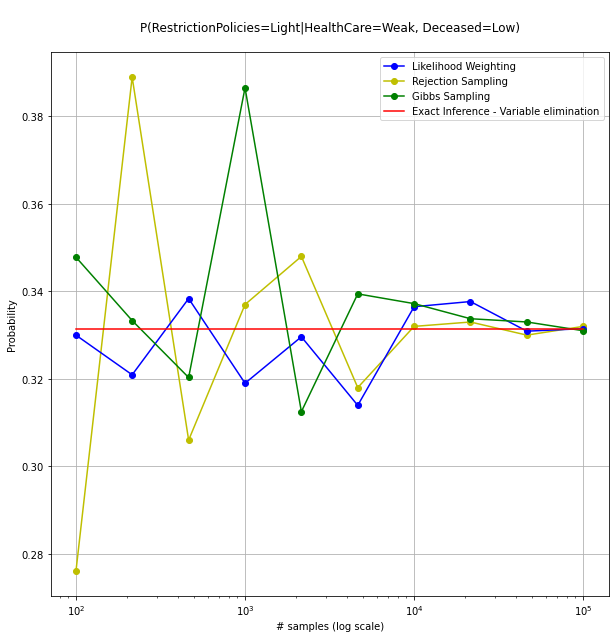

In [22]:
plot_results(approximate_results, query.values[1], '\nP(RestrictionPolicies=Light|HealthCare=Weak, Deceased=Low)\n')


In [23]:
approximate_results = np.array([],
                    dtype=[('sample_size', '<i8'), 
                           ('RS', '<f8'),
                           ('LW', '<f8'),
                           ('GS', '<f8')])
initial_size = 2
final_size = 5
num = 10

for size in np.logspace(initial_size, final_size, num=num, dtype='<i8'):
    print()
    print("="*50)
    print(size)
    approximate_results=np.append(approximate_results, samplings(size,variable=["RP",">=","Light"],evidence=[State('HC',"Weak"), State('De','Low')]))

Generating for node: Age:   0%|          | 0/10 [00:00<?, ?it/s]
1000

Generating for node: De: 100%|██████████| 10/10 [00:00<00:00, 43.48it/s]
1254it [00:00, 2628.92it/s]
  0%|          | 0/2154 [00:00<?, ?it/s]
2154

Generating for node: De: 100%|██████████| 10/10 [00:00<00:00, 26.74it/s]
2849it [00:00, 4500.79it/s]
Eliminating: GDP: 100%|██████████| 9/9 [00:00<00:00, 125.00it/s]

4641
Generating for node: De: 100%|██████████| 10/10 [00:00<00:00, 13.97it/s]
6066it [00:01, 5344.50it/s]
Finding Elimination Order: : 100%|██████████| 9/9 [00:00<00:00, 2249.76it/s]
10000

Generating for node: De: 100%|██████████| 10/10 [00:01<00:00,  7.49it/s]
12818it [00:02, 6228.37it/s]
Eliminating: GDP: 100%|██████████| 9/9 [00:00<00:00, 123.29it/s]

21544
Generating for node: De: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]
27908it [00:04, 5908.08it/s]
Eliminating: GDP: 100%|██████████| 9/9 [00:00<00:00, 138.46it/s]

46415
Generating for node: De: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]
613

In [24]:
print(approximate_results)

[(   100, 0.773, 0.7       , 0.75      )
 (   215, 0.733, 0.72093023, 0.62121212)
 (   464, 0.752, 0.71551724, 0.72093023)
 (  1000, 0.726, 0.698     , 0.74230769)
 (  2154, 0.736, 0.72237697, 0.73204904)
 (  4641, 0.744, 0.73884939, 0.73663208)
 ( 10000, 0.734, 0.7286    , 0.71568627)
 ( 21544, 0.734, 0.73082993, 0.73017835)
 ( 46415, 0.738, 0.73206937, 0.72067725)
 (100000, 0.74 , 0.72972   , 0.7272589 )]


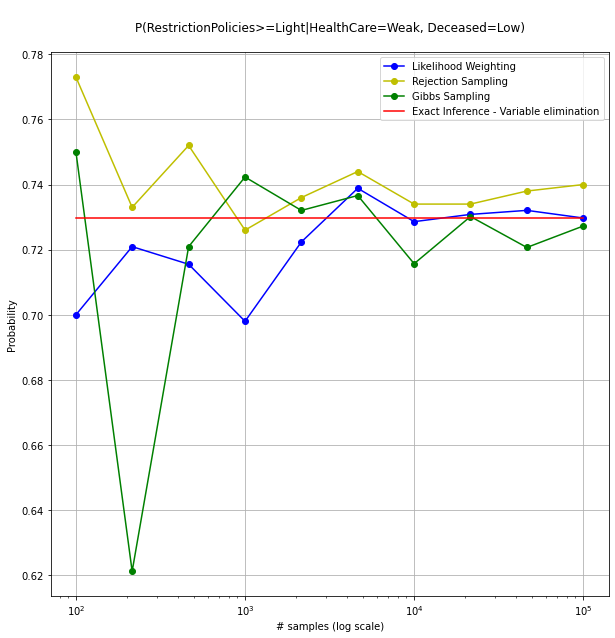

In [25]:
plot_results(approximate_results, sum(query.values[1:]), '\nP(RestrictionPolicies>=Light|HealthCare=Weak, Deceased=Low)\n')

## Further studies
It could be interesting to study a similar model but from a dynamic perspective. Thus, integrating the time factor.

The approximate inference is an important algorithm in some areas of intelligent systems, some machine learning areas make huge use of these algorithms. Maybe it would be interesting to cross the study of inference sampling with other areas of artificial intelligence such as optimization. We can parameterise the approximation with some variational parameters, and then minimise a probabilistic divergence (e.g., the Kullback-Liebler divergence) w.r.t. the variational parameters.  Moreover, I see some integration with evolutionary computing, where we can optimize the prior distribution by selecting the best generations.

### Not Reliable References
<i>Wikipedia is not a reliable source, anyway, we just need indicative data.</i>


<a href="https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population#Lists_of_countries_by_population">[1] Wikipedia: List of countries by population</a>
<br>
<a href="https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population_density">[2] Wikipedia: List of countries by density</a>
<br>
<a href="https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)">[3] Wikipedia: List of countries by GDP (nominal)</a>
<br>
<a href="https://en.wikipedia.org/wiki/List_of_countries_by_median_age">[4] Wikipedia: List of countries by median age</a>



### References
<a href="https://www.who.int/healthinfo/paper30.pdf">[5] WHO - Measuring Overall Health System Performance for 191 Countries</a>
<br>
<a href=https://library.bayesia.com/articles/#!bayesialab-knowledge-hub/epidemic-modeling-with-bayesian-networks> [6] Tech Talk: Epidemic Modeling with Bayesian Networks</a>
<br>
<a href=https://library.bayesia.com/articles/#!bayesialab-knowledge-hub/webinars-seminars-case-studies> [7] BayesiaLab Webinars, Seminars, Tutorials, Examples, & Case Studies </a>
<br>
<a href=ttps://coronavirus.jhu.edu/data/mortality> [8] Johns Hopkins University - Mortality in the most affected countries by COVID-19 </a>
<br>
<a href=https://programtalk.com/vs2/python/10105/pgmpy/pgmpy/tests/test_sampling> [9] Examples of pgmpy samplings </a>

---------------------------------------------------------------